In [1]:
import rasterio
from scipy.ndimage import uniform_filter
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib

In [2]:
extended_file_name="_reproject"
output_model_dir="output/model/"
# sar_image_path = "output/sar_image/eaton_sar_indices.tif"
sar_image_path = "output/sar_image/palisades_sar_indices.tif"




In [3]:
dataset = rasterio.open(sar_image_path)
print(dataset.count)

# Iterate through all bands
for band in range(1, dataset.count + 1):
    band_data = dataset.read(band)  # Read the band
    min_val = np.min(band_data)
    max_val = np.max(band_data)
    
    print(f"Band {band}: Min = {min_val}, Max = {max_val}")

# Close the dataset
dataset.close()

8
Band 1: Min = -691.3224487304688, Max = 309.0826110839844
Band 2: Min = -56.4168586730957, Max = 23.925006866455078
Band 3: Min = -3.111504554748535, Max = 3.8037984371185303
Band 4: Min = -2.6249442100524902, Max = 3.039884567260742
Band 5: Min = -26.075912475585938, Max = 30.923128128051758
Band 6: Min = -37.22654342651367, Max = 32.28765869140625
Band 7: Min = -1.8715726137161255, Max = 1.8734556436538696
Band 8: Min = -693.9559936523438, Max = 309.1387939453125


In [4]:
def predict(model, image_path,model_name ):
    dataset = rasterio.open(image_path)
    print(dataset.count)

    # # Load the SAR GeoTIFF
    # image_path = "../SAR_Data_processing/11_export/palisades_indices_subset.tif"
    # dataset = rasterio.open(image_path)

    # Read the image bands into an array (assuming it's a multi-band raster)
    sar_bands = np.stack([dataset.read(i+1) for i in range(dataset.count)], axis=-1)

    # Reshape the SAR data to a 2D array (num_pixels, num_bands)
    height, width, num_bands = sar_bands.shape
    pixels = sar_bands.reshape(-1, num_bands)  # Each row is a pixel
    print(num_bands,"num_bands")

    # Preprocess (scale) the pixel values if needed (based on training data preprocessing)
    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels

    # Predict for each pixel
    predictions = model.predict(pixels)

    # Assuming predictions are a 2D array (for an image or spatial data)
    predictions = uniform_filter(predictions, size=7)  # size is the window size

    # predictions = model.predict(scaler.transform(pixels))


    # Reshape predictions to match the image dimensions
    predicted_image = predictions.reshape(height, width)

    # Save the predicted classes to a new file
    output_path = f"output/prediction/eaton_{model_name}_{extended_file_name}.tif"
    meta = dataset.meta
    meta.update(dtype=rasterio.uint8, count=1)  # Assuming class labels are integers, uint8 works for this

    with rasterio.open(output_path, 'w', **meta) as dest:
        dest.write(predicted_image.astype(rasterio.uint8), 1)  # Write to the first band

    print(f"Predictions saved to {output_path}")

    pred_dataset = rasterio.open(output_path)

    # Read the first band of the image (you can adjust for multi-band images)
    pred_band_1 = pred_dataset.read(1)

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(pred_band_1, cmap='gray')  # You can adjust the colormap if needed
    plt.colorbar()
    plt.title("SAR Burnt Area Prediction Map")
    plt.show()


8
8 num_bands


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predictions saved to output/prediction/eaton_RandomForest0__reproject.tif


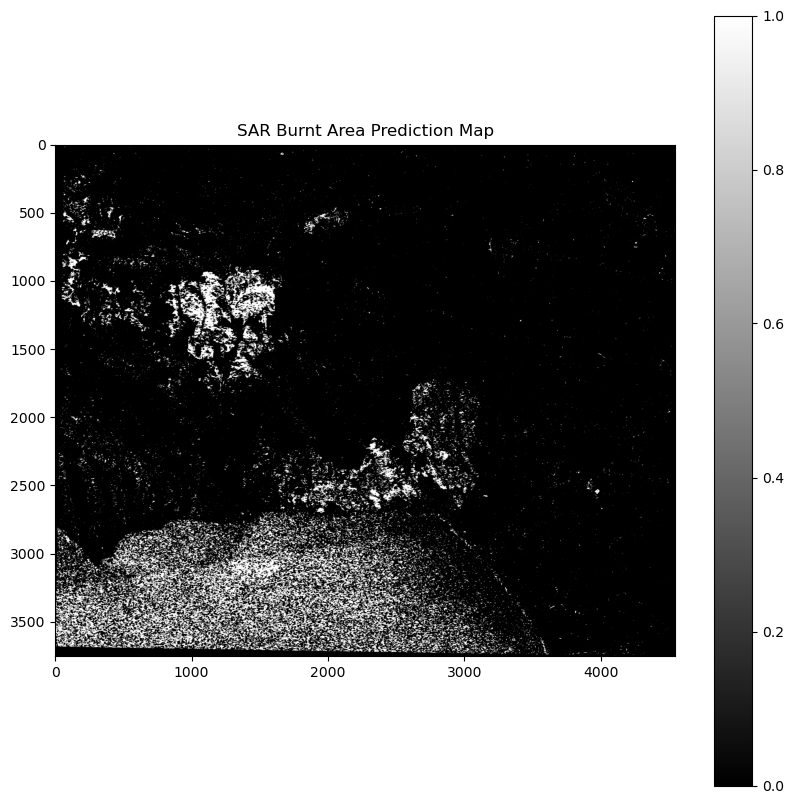

In [5]:
ml_models=os.listdir(output_model_dir)
for model_name in ml_models:
    output_model_path = os.path.join(output_model_dir, model_name)
    # Load the saved model
    loaded_model = joblib.load(output_model_path)

    # Use the loaded model to make predictions
    # predictions = loaded_model.predict(X_test)
    predict(loaded_model, sar_image_path,model_name.replace(".pkl",""))